<a href="https://colab.research.google.com/github/alistairewj/mimic-iv-aline-study/blob/master/mimic_iv_aline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arterial line study

This notebook reproduces the arterial line study in MIMIC-IV. The following is an outline of the notebook:

1. Combine previously generated tables to acquire a single dataframe
2. Propensity match this dataframe

Note that the original arterial line study used a genetic algorithm to select the covariates in the propensity score. We omit the genetic algorithm step, and instead use the final set of covariates described by the authors. For more detail, see:

> Hsu DJ, Feng M, Kothari R, Zhou H, Chen KP, Celi LA. The association between indwelling arterial catheters and mortality in hemodynamically stable patients with respiratory failure: a propensity score analysis. CHEST Journal. 2015 Dec 1;148(6):1470-6.

**YOU MUST RUN THE BELOW CELL AND RESTART AFTERWARD.**
We are required to downgrade pandas in order to use the pymatch package. After downgrading pandas, you'll have to restart the runtime.

In [ ]:
# downgrade pandas - the pymatch package requires an older version of pandas
# you can ignore the warnings, happily none of them break!
!pip install pandas==0.22 --upgrade

  Using cached https://files.pythonhosted.org/packages/da/c6/0936bc5814b429fddb5d6252566fe73a3e40372e6ceaf87de3dec1326f28/pandas-0.22.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/93/0b/71ae818646c1a80fbe6776d41f480649523ed31243f1f34d9d7e41d70195/numpy-1.19.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4f/a4/879454d49688e2fad93e59d7d4efda580b783c745fd2ec2a3adf87b0808d/pytz-2020.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ee/ff/48bde5c0f013094d729fe4b0316ba2a24774b3ff1c52d924a8a4cb04078a/six-1.15.0-py2.py3-none-any.whl
ERROR: xarray 0.15.1 has requirement pandas>=0.25, but you'll have pandas 0.22.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.22.

In [ ]:
# Import libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import chi2, norm
import matplotlib.pyplot as plt

# below is used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline


plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [16, 12]})

# we will load data from tables generated on BigQuery
from google.colab import auth
from google.cloud import bigquery

project_id='lcp-internal'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

In [ ]:
# authenticate
auth.authenticate_user()

## Summarize exclusions

In [ ]:
query = """
select
stay_id
, exclusion_readmission
, exclusion_shortstay
, exclusion_vasopressors
, exclusion_septic
, exclusion_aline_before_admission
, exclusion_not_ventilated_first24hr
, exclusion_service_surgical
from aline.cohort_all
"""

# Load the result of the query into a dataframe
df = run_query(query)

# print out exclusions
idxRem = df['stay_id'].isnull()
for c in df.columns:
    if 'exclusion_' in c:
        print('{:5d} - {}'.format(df[c].sum(), c))
        idxRem[df[c]==1] = True   
        
# final exclusion (excl sepsis/something else)
print('Will remove {} of {} patients.'.format(np.sum(idxRem), df.shape[0]))


print('')
print('')
print('Replicating the flow of the flowchart from Chest paper.')

# first stay
idxRem = (df['exclusion_readmission']==1) | (df['exclusion_shortstay']==1)
print('{:5d} - removing {:5d} ({:2.2f}%) patients - short stay // readmission.'.format(
        df.shape[0], np.sum(idxRem), 100.0*np.mean(idxRem)))
df = df.loc[~idxRem,:]

idxRem = df['exclusion_not_ventilated_first24hr']==1
print('{:5d} - removing {:5d} ({:2.2f}%) patients - not ventilated in first 24 hours.'.format(
        df.shape[0], np.sum(idxRem), 100.0*np.mean(idxRem)))

df = df.loc[df['exclusion_not_ventilated_first24hr']==0,:]

print('{:5d}'.format(df.shape[0]))
idxRem = df['stay_id'].isnull()
for c in ['exclusion_septic', 'exclusion_vasopressors',
            'exclusion_aline_before_admission', 'exclusion_service_surgical']:
    print('{:5s} - removing {:5d} ({:2.2f}%) patients - additional {:5d} {:2.2f}% - {}'.format(
            '', df[c].sum(), 100.0*df[c].mean(),
            np.sum((idxRem==0)&(df[c]==1)), 100.0*np.mean((idxRem==0)&(df[c]==1)),
            c))
    idxRem = idxRem | (df[c]==1)

df = df.loc[~idxRem,:]
print('{} - final cohort.'.format(df.shape[0]))

19583 - exclusion_readmission
 5670 - exclusion_shortstay
22518 - exclusion_vasopressors
20924 - exclusion_septic
11888 - exclusion_aline_before_admission
50257 - exclusion_not_ventilated_first24hr
18550 - exclusion_service_surgical
Will remove 66873 of 69612 patients.


Replicating the flow of the flowchart from Chest paper.
69612 - removing 23729 (34.09%) patients - short stay // readmission.
45883 - removing 31286 (68.19%) patients - not ventilated in first 24 hours.
14597
      - removing  4555 (31.21%) patients - additional  4555 31.21% - exclusion_septic
      - removing  8847 (60.61%) patients - additional  5883 40.30% - exclusion_vasopressors
      - removing  5713 (39.14%) patients - additional  1072 7.34% - exclusion_aline_before_admission
      - removing  6236 (42.72%) patients - additional   348 2.38% - exclusion_service_surgical
2739 - final cohort.


In [ ]:
1776/22443

0.0791338056409571

## Extract all covariates and outcome measures

We now aggregate all the data from the various views into a single dataframe.

In [ ]:
query = """
--FINAL QUERY
select
  co.subject_id, co.hadm_id, co.stay_id

  -- static variables from patient tracking tables
  , co.age
  , co.gender
  -- , co.gender_num -- gender, 0=F, 1=M
  , co.intime as icustay_intime
  --, co.day_icu_intime -- day of week, text
  --, co.day_icu_intime_num -- day of week, numeric (0=Sun, 6=Sat)
  , co.hour_icu_intime -- hour of ICU admission (24 hour clock)
  , case 
      when co.hour_icu_intime >= 7
       and co.hour_icu_intime < 19
         then 1
      else 0
    end as icu_hour_flag
  , co.outtime as icustay_outtime

  -- outcome variables
  , co.icu_los_day
  , co.hospital_los_day
  , co.hosp_exp_flag -- 1/0 patient died within current hospital stay
  , co.icu_exp_flag -- 1/0 patient died within current ICU stay
  , co.mort_day -- days from ICU admission to mortality, if they died
  , co.day_28_flag -- 1/0 whether the patient died 28 days after *ICU* admission
  , co.mort_day_censored -- days until patient died *or* 150 days (150 days is our censor time)
  , co.censor_flag -- 1/0 did this patient have 150 imputed in mort_day_censored

  -- aline flags
  -- , co.initial_aline_flag -- always 0, we remove patients admitted w/ aline
  , co.aline_flag -- 1/0 did the patient receive an aline
  , co.aline_time_day -- if the patient received aline, fractional days until aline put in

  -- demographics extracted using regex + echos
  , bmi.weight as weight_first
  , bmi.height as height_first
  , bmi.bmi

  -- service patient was admitted to the ICU under
  , co.service_unit

  -- severity of illness just before ventilation
  , so.sofa as sofa_first

  -- vital sign value just preceeding ventilation
  , vi.map as map_first
  , vi.heartrate as hr_first
  , vi.temperature as temp_first
  , vi.spo2 as spo2_first

  -- labs!
  , labs.bun_first
  , labs.creatinine_first
  , labs.chloride_first
  , labs.hgb_first
  , labs.platelet_first
  , labs.potassium_first
  , labs.sodium_first
  , labs.tco2_first
  , labs.wbc_first

  -- comorbidities extracted using ICD-9 codes
  , icd.chf as chf_flag
  , icd.afib as afib_flag
  , icd.renal as renal_flag
  , icd.liver as liver_flag
  , icd.copd as copd_flag
  , icd.cad as cad_flag
  , icd.stroke as stroke_flag
  , icd.malignancy as malignancy_flag
  , icd.respfail as respfail_flag
  , icd.endocarditis as endocarditis_flag
  , icd.ards as ards_flag
  , icd.pneumonia as pneumonia_flag

  -- sedative use
  , sed.sedative_flag
  , sed.dilaudid_flag
  , sed.midazolam_flag
  , sed.fentanyl_flag
  , sed.propofol_flag
  
from aline.cohort co
-- The following tables are generated by code within this repository
left join aline.sofa so
on co.stay_id = so.stay_id
left join aline.bmi bmi
  on co.stay_id = bmi.stay_id
left join aline.icd icd
  on co.hadm_id = icd.hadm_id
left join aline.vitals vi
  on co.stay_id = vi.stay_id
left join aline.labs labs
  on co.stay_id = labs.stay_id
left join aline.sedatives sed
  on co.stay_id = sed.stay_id
order by co.stay_id
"""

# Load the result of the query into a dataframe
df = run_query(query)

# add service_surgical variable
df['service_surgical'] = df['service_unit'].isin(['SURG', 'NSURG', 'PSURG']).astype(int)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,2739.0,1.502043e+07,2.894535e+06,1.001728e+07,1.246776e+07,1.501432e+07,1.753587e+07,1.999114e+07
hadm_id,2739.0,2.498142e+07,2.903268e+06,2.000295e+07,2.248825e+07,2.494032e+07,2.750915e+07,2.999722e+07
stay_id,2739.0,3.500826e+07,2.869314e+06,3.000101e+07,3.255738e+07,3.502345e+07,3.752016e+07,3.999264e+07
age,2739.0,5.793647e+01,1.965200e+01,1.800000e+01,4.400000e+01,5.800000e+01,7.400000e+01,9.100000e+01
hour_icu_intime,2739.0,1.308653e+01,7.551781e+00,0.000000e+00,6.000000e+00,1.500000e+01,2.000000e+01,2.300000e+01
icu_hour_flag,2739.0,3.990507e-01,4.897926e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
icu_los_day,2739.0,3.568091e+00,3.973619e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,4.500000e+01
hospital_los_day,2739.0,8.485214e+00,8.542511e+00,0.000000e+00,4.000000e+00,6.000000e+00,1.000000e+01,1.310000e+02
hosp_exp_flag,2739.0,1.310697e-01,3.375382e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
icu_exp_flag,2739.0,9.127419e-02,2.880512e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Now we need to remove obvious outliers! We histogram each column to check for outliers.

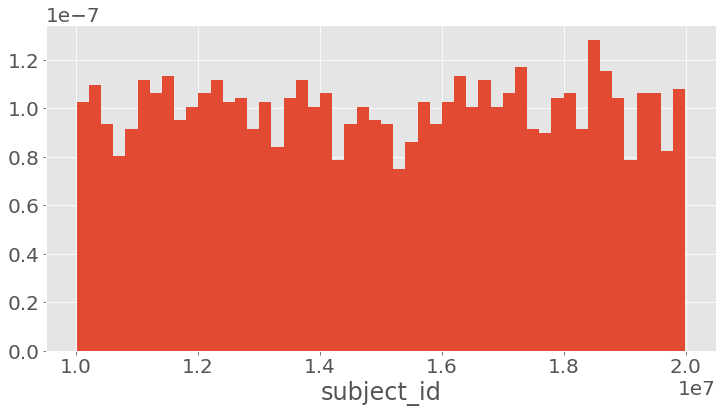

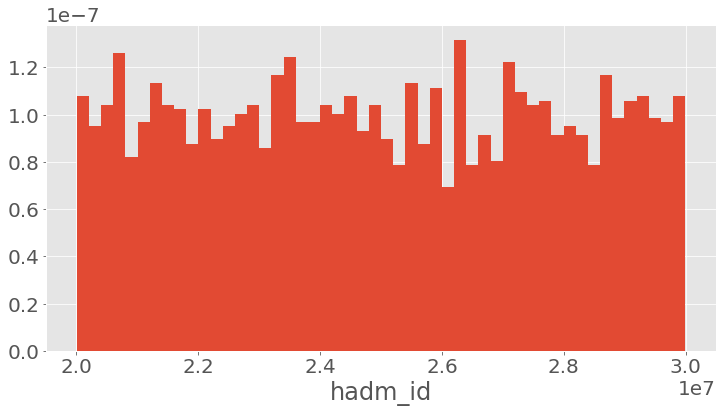

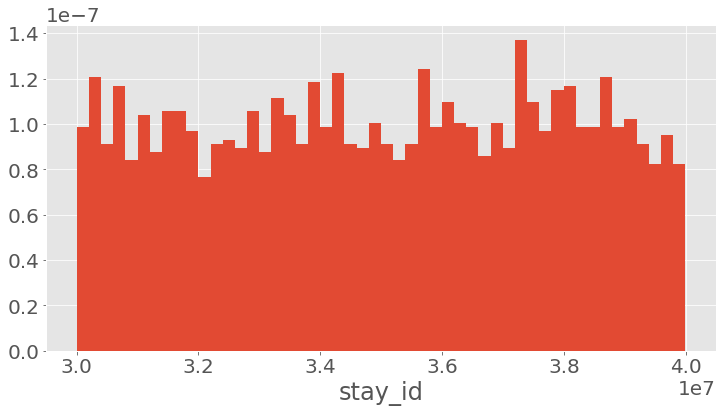

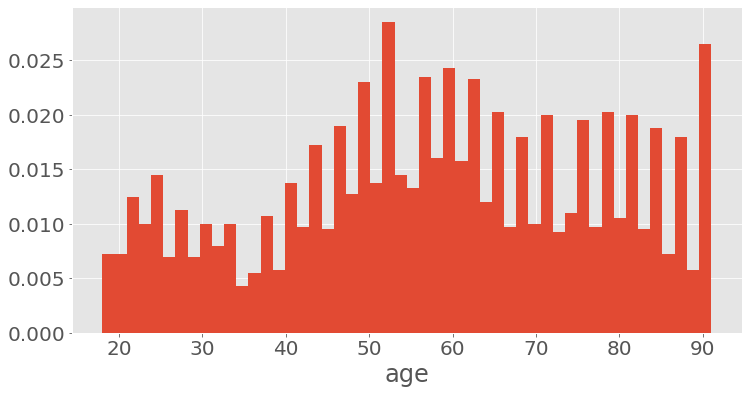

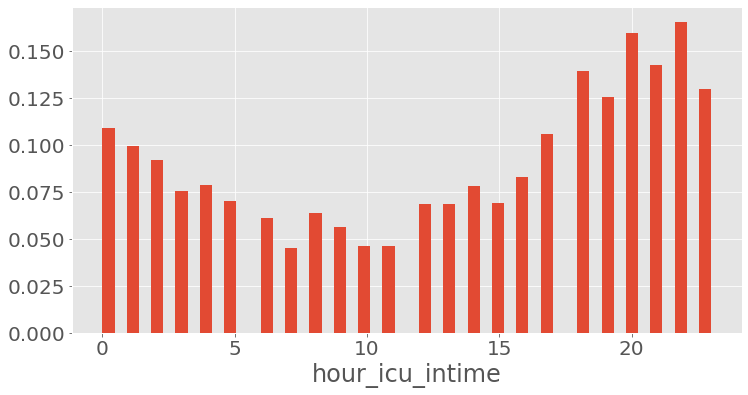

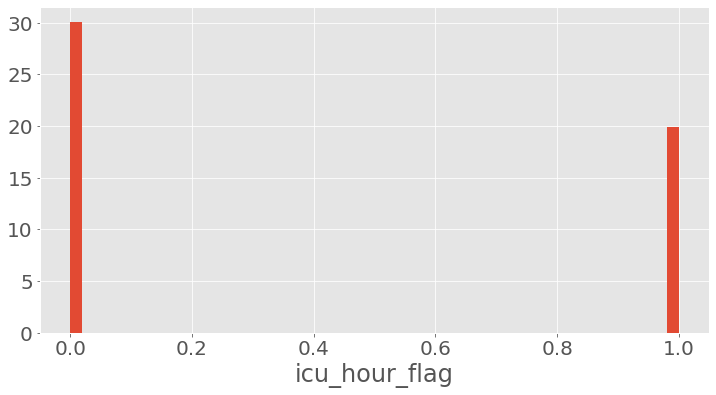

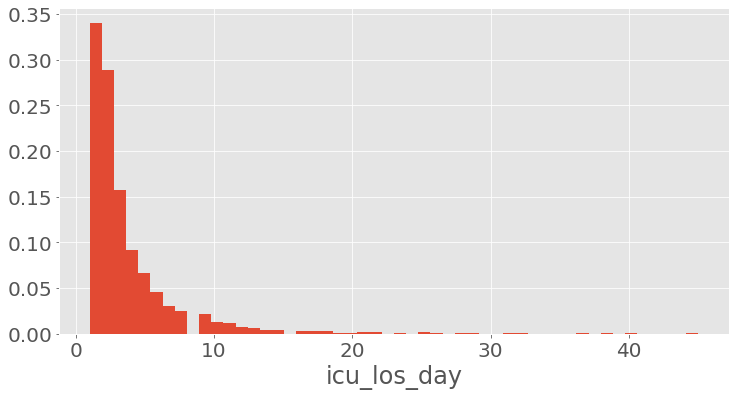

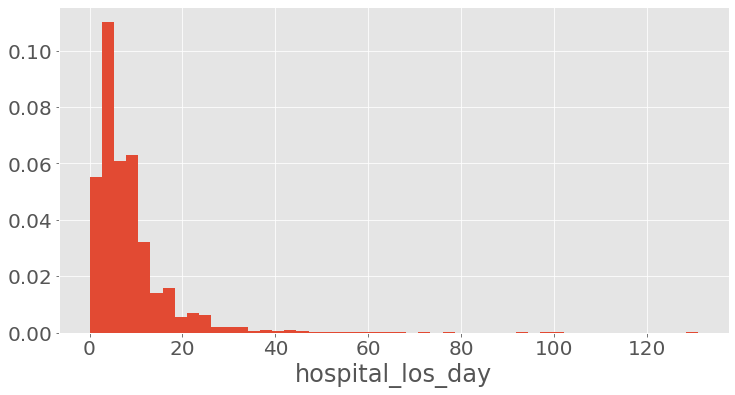

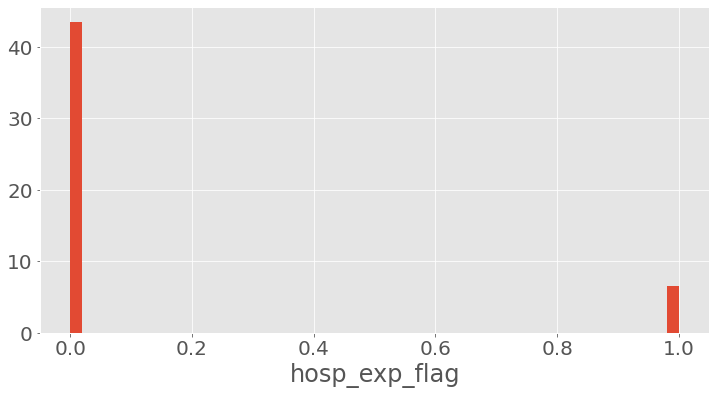

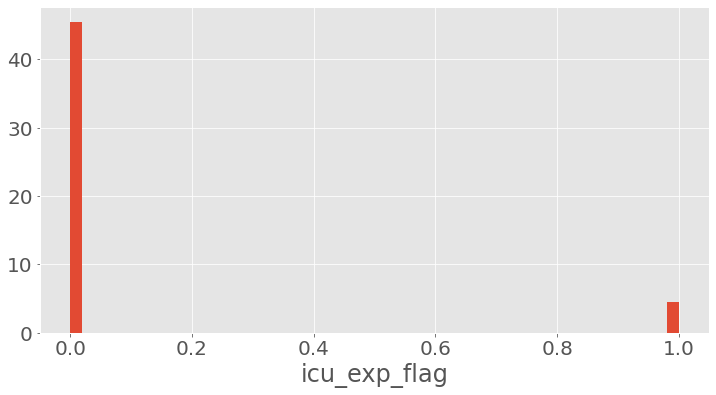

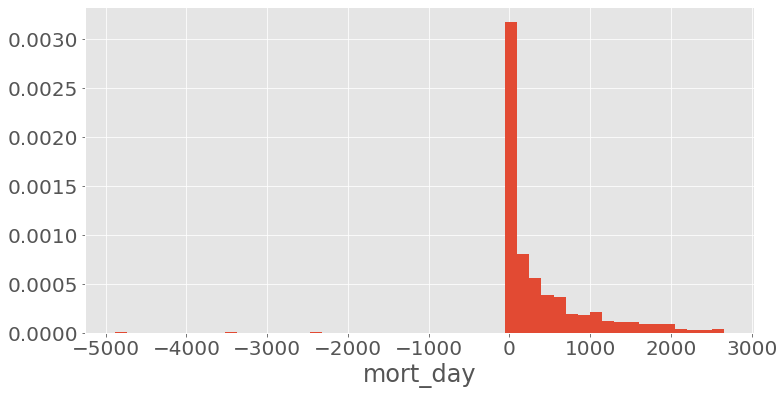

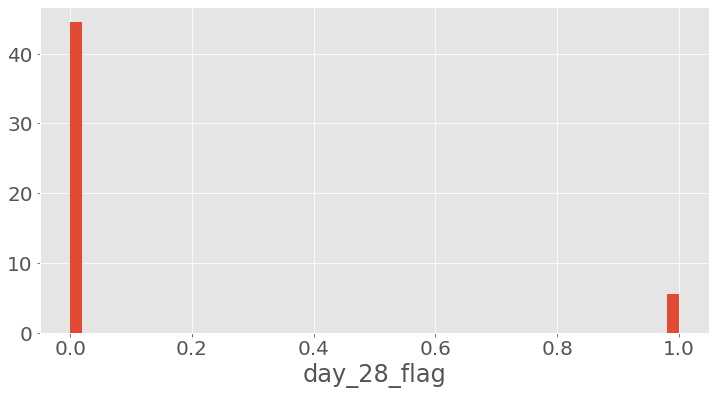

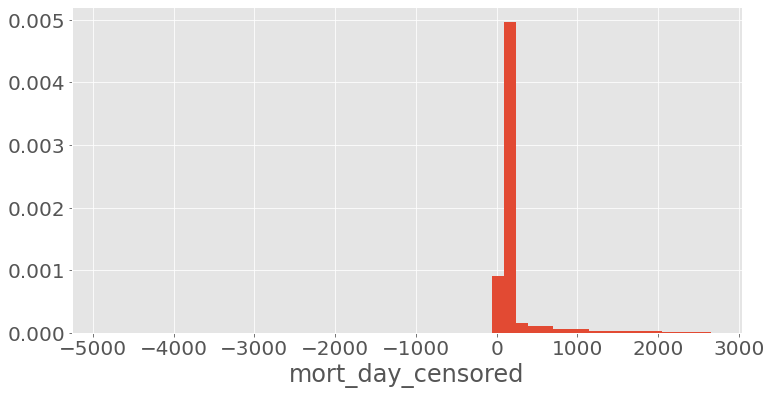

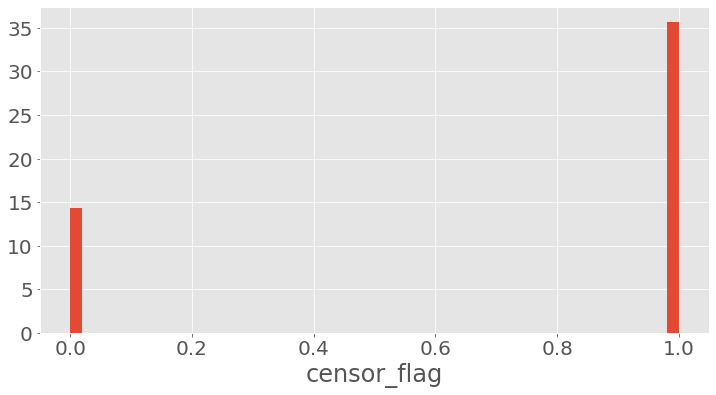

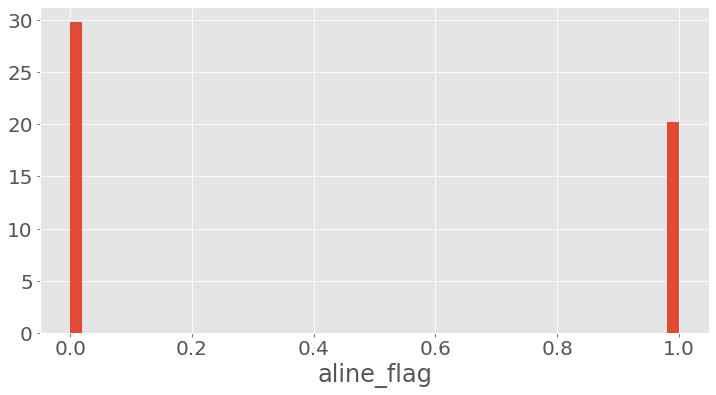

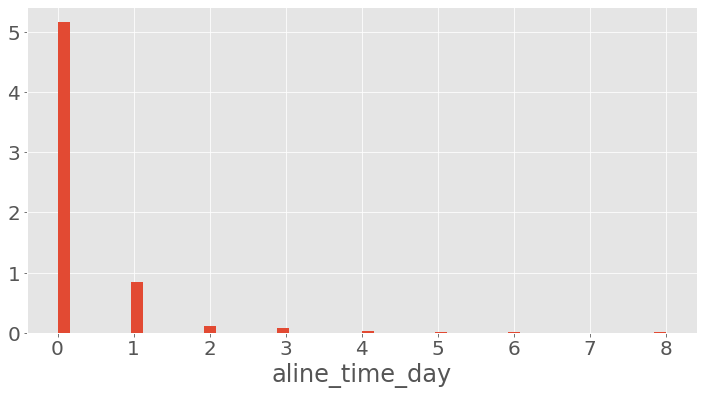

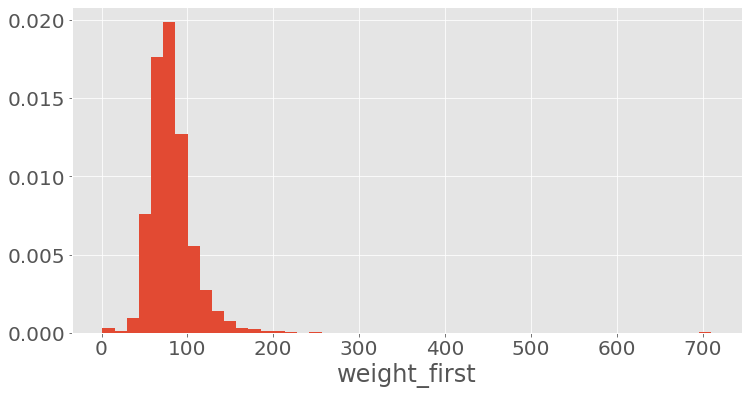

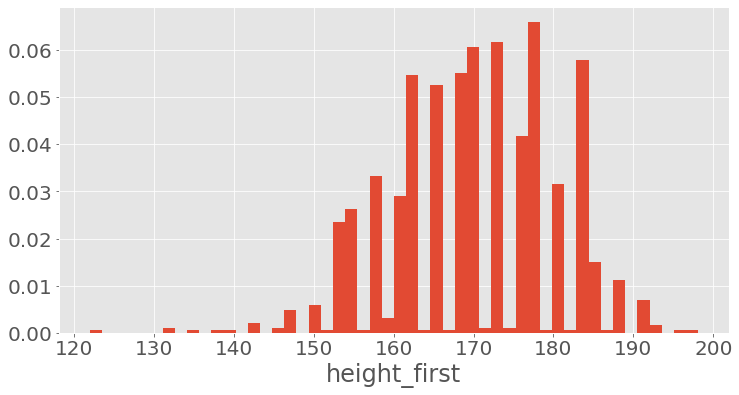

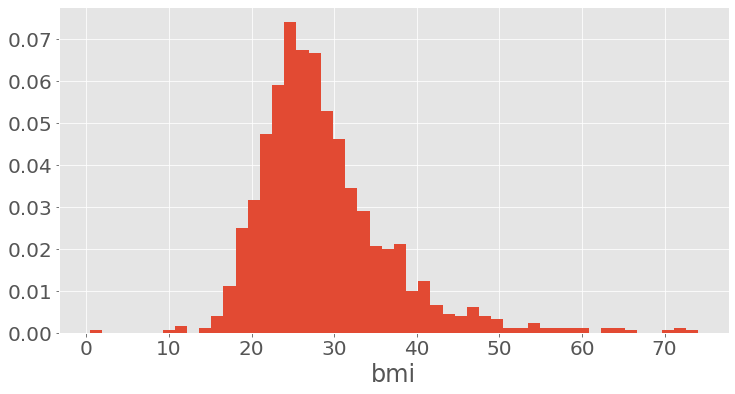

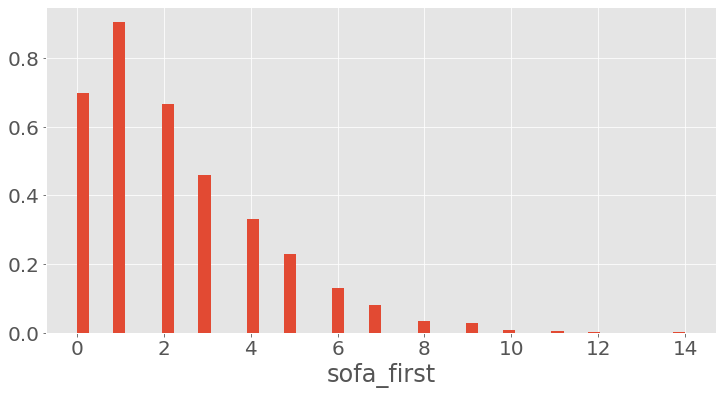

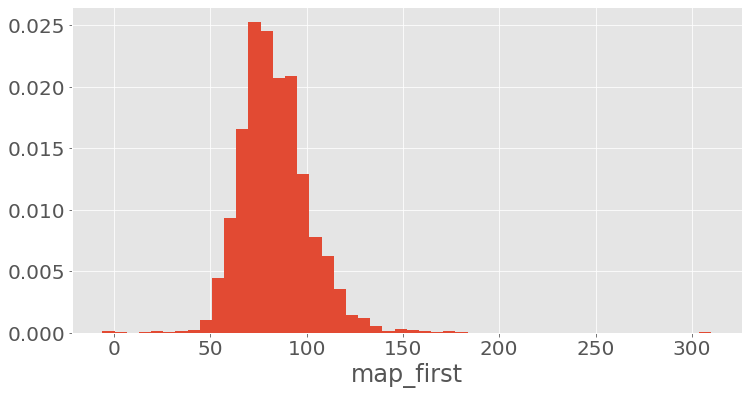

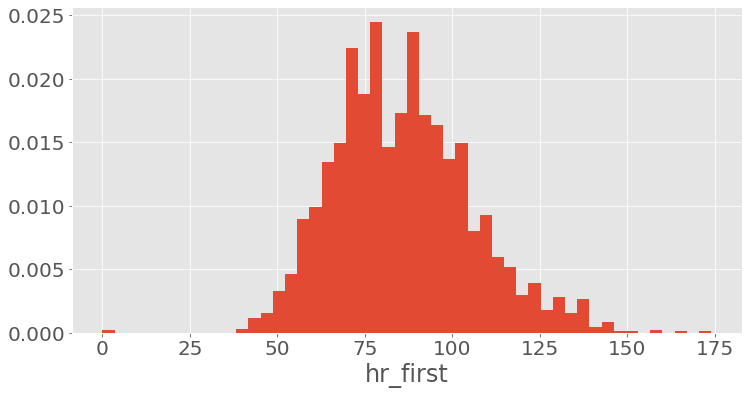

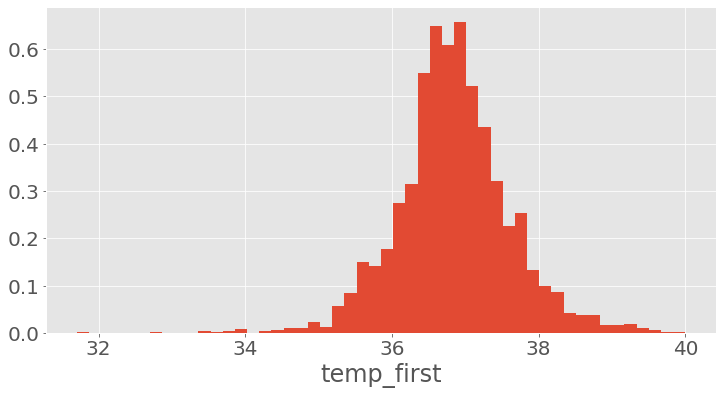

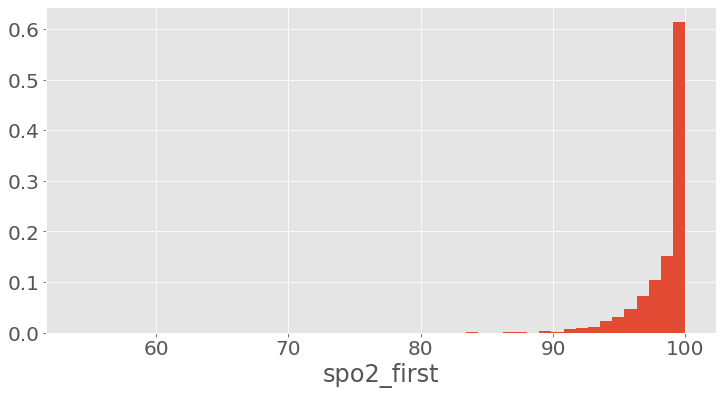

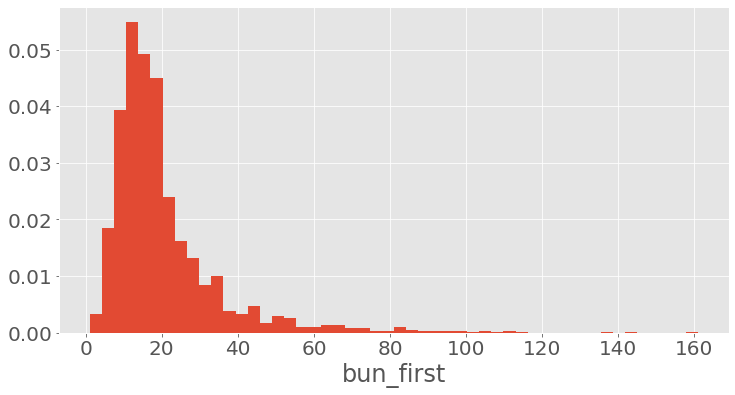

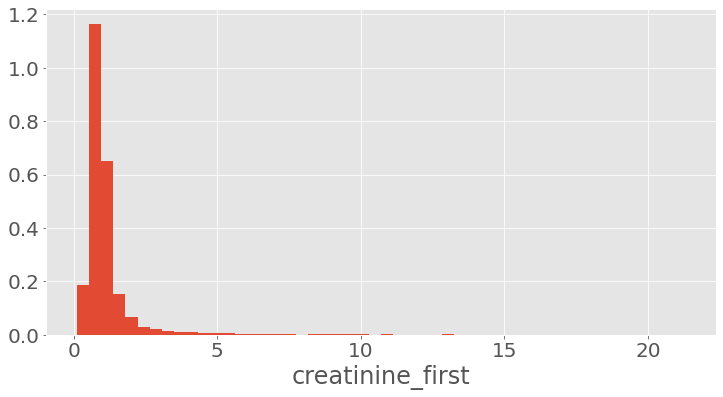

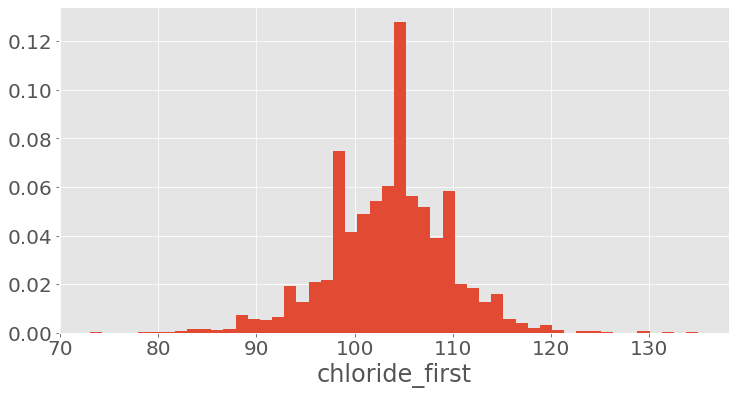

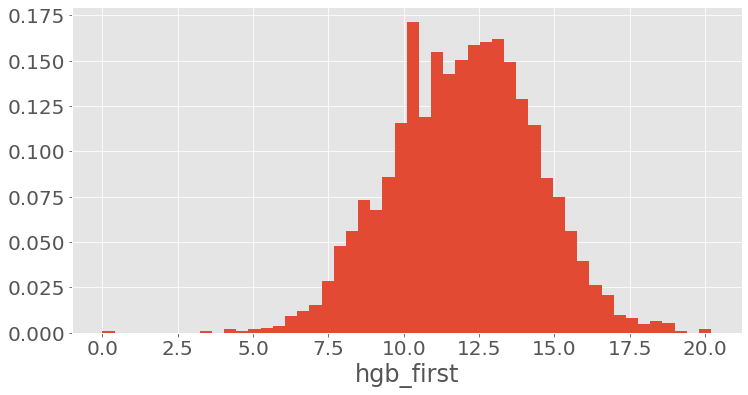

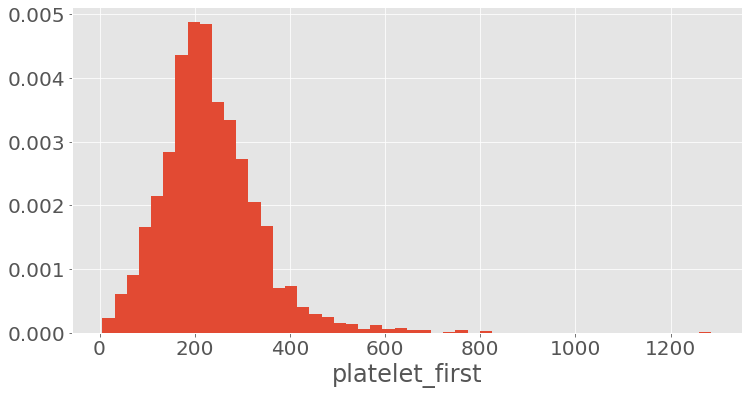

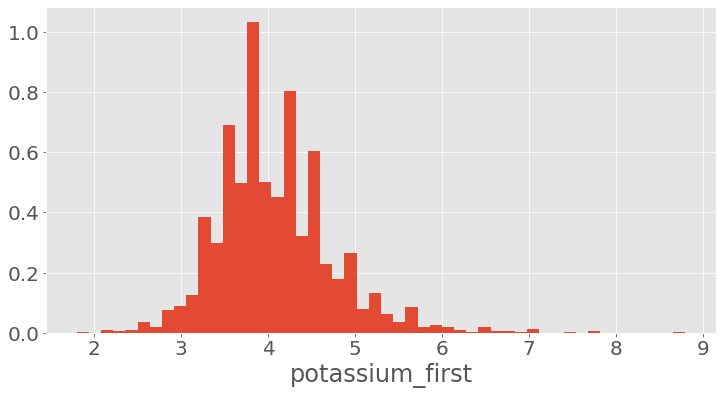

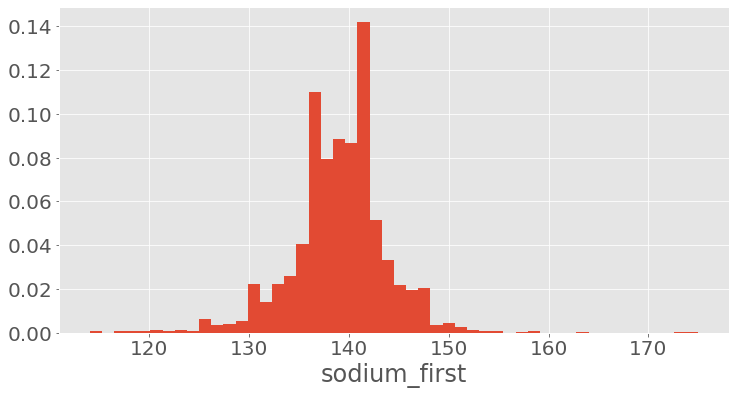

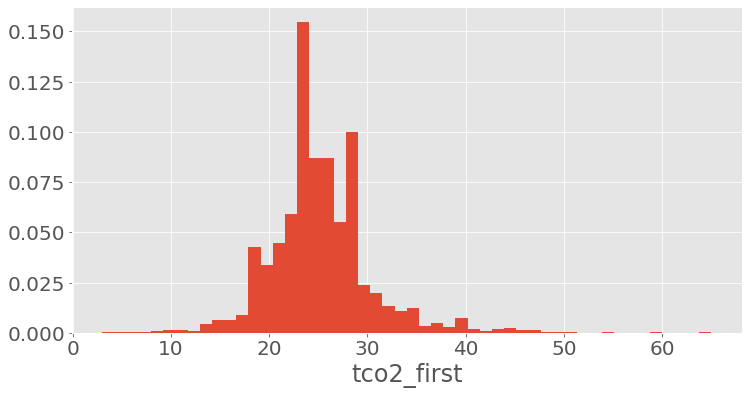

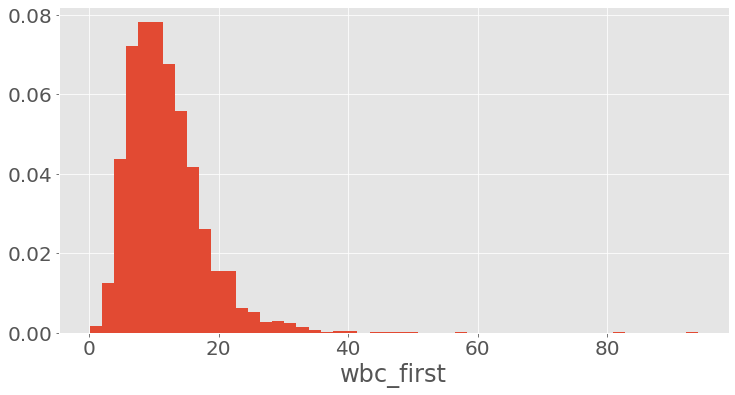

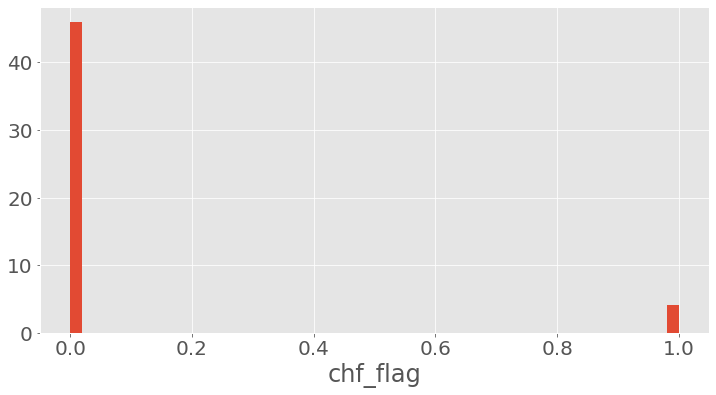

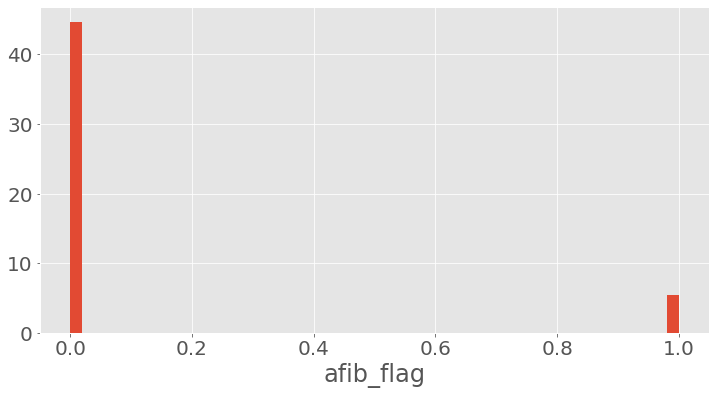

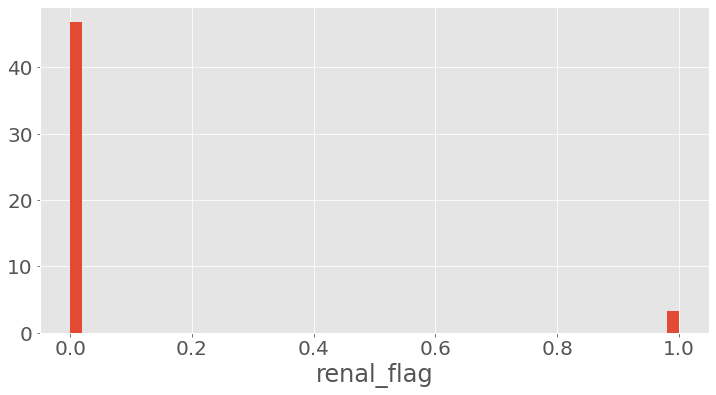

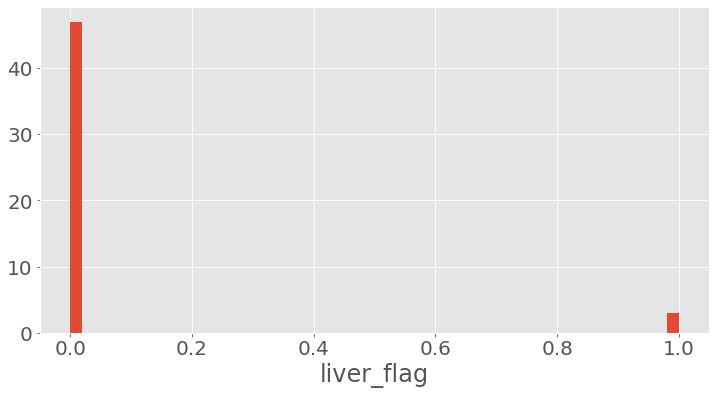

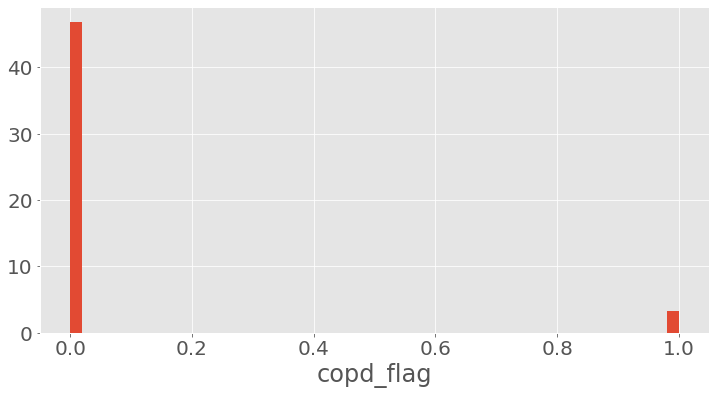

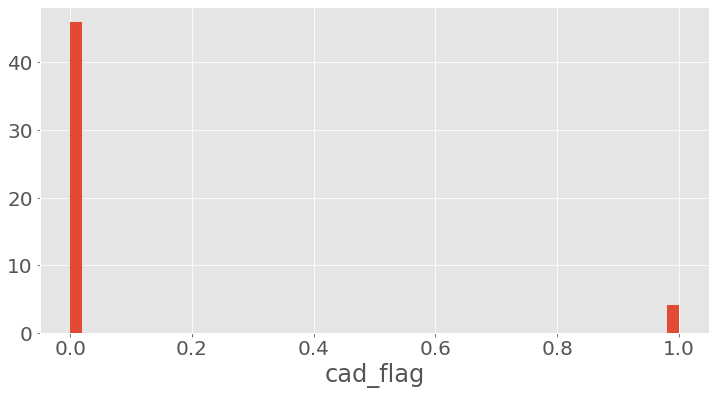

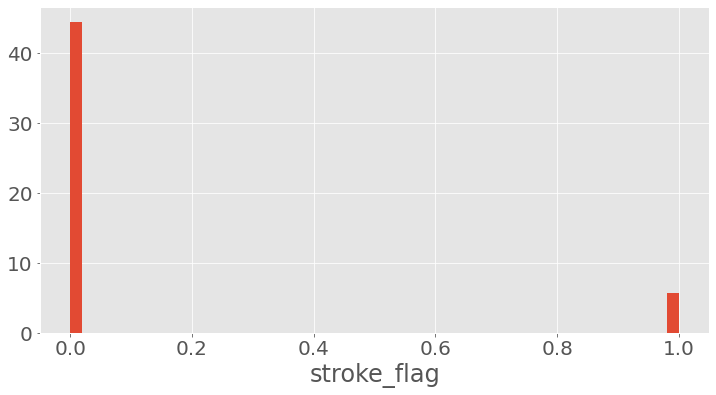

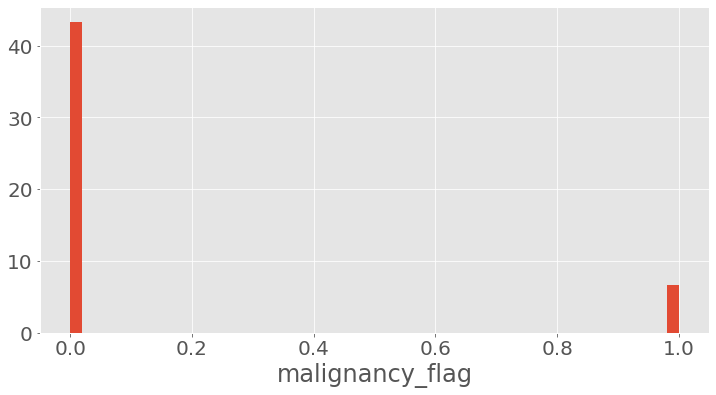

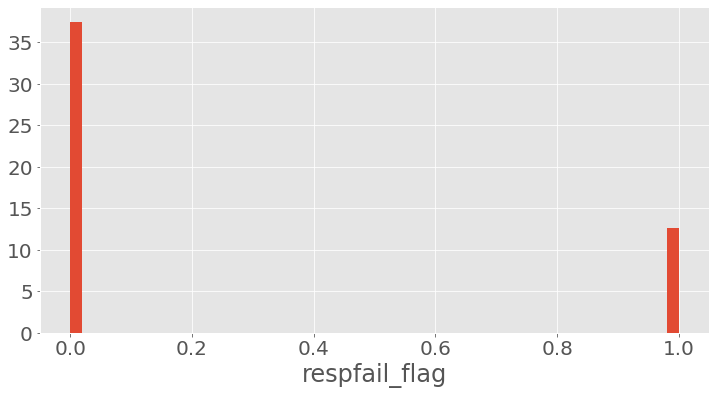

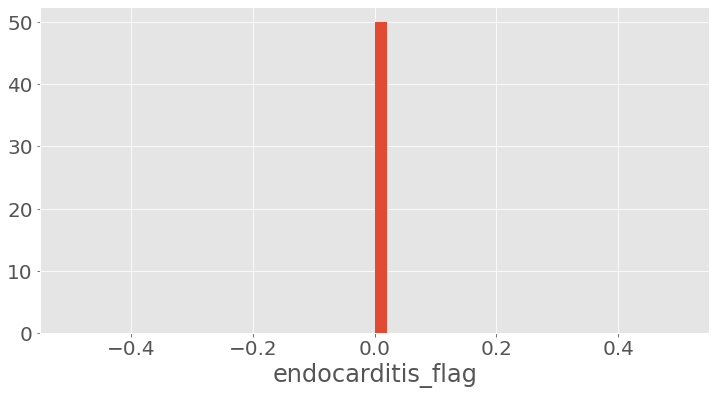

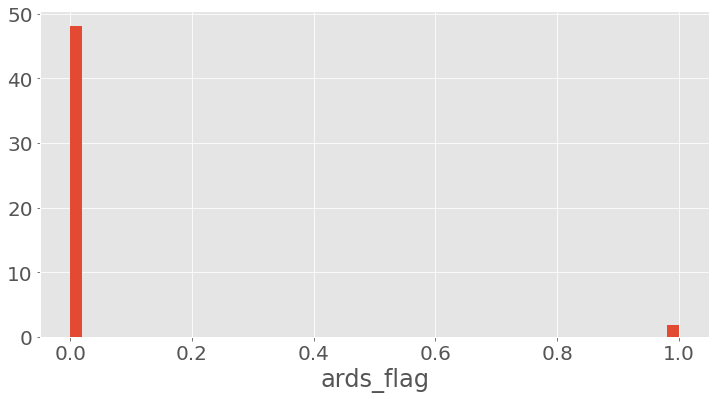

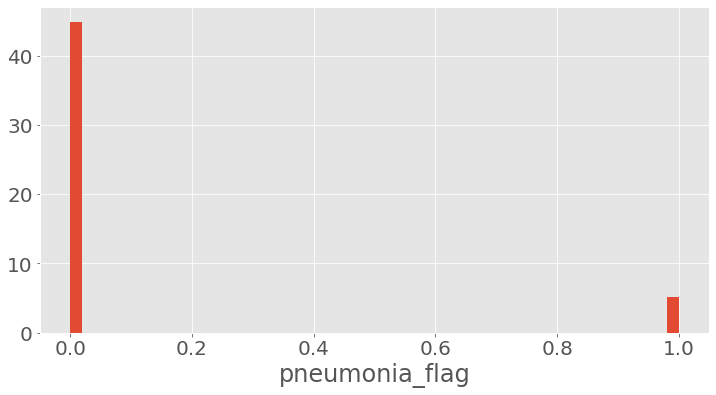

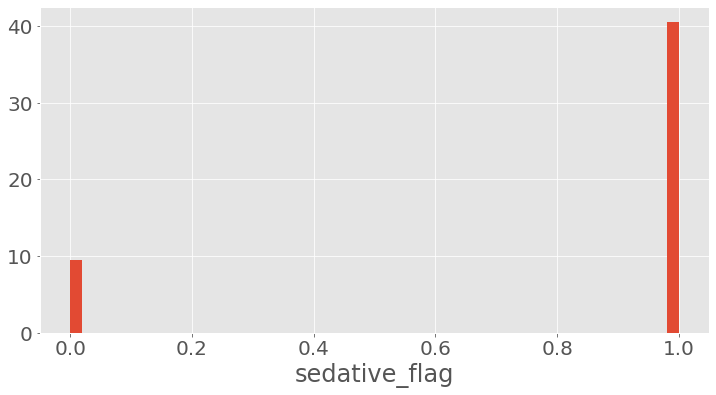

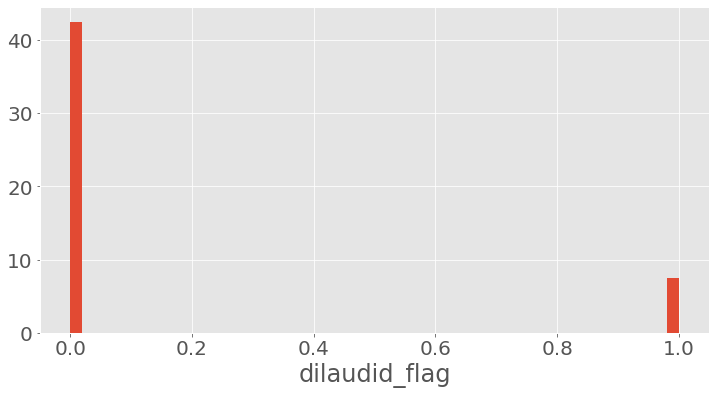

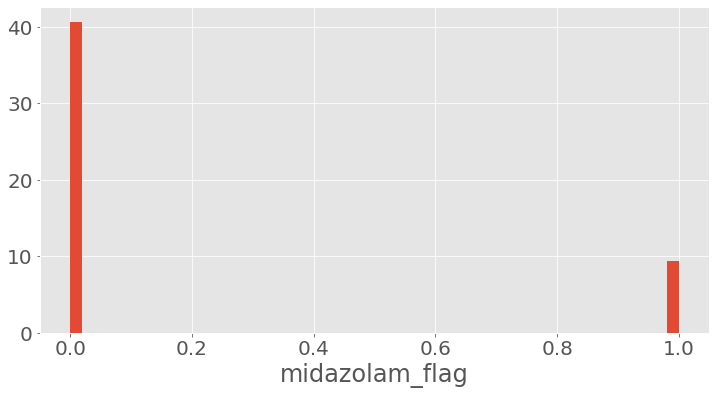

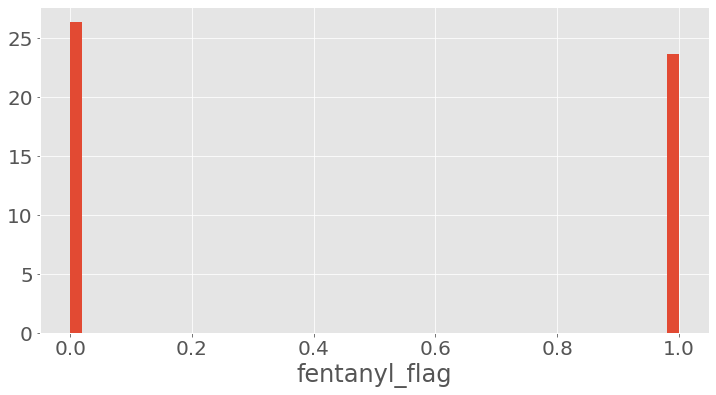

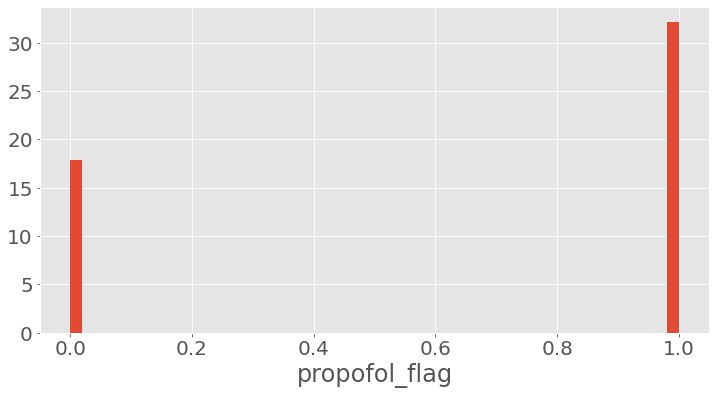

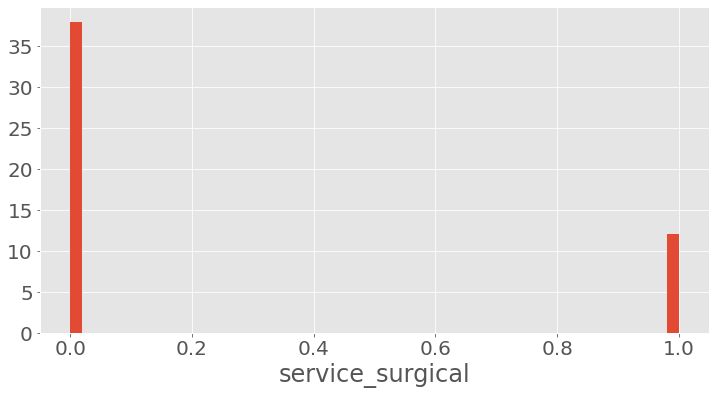

In [ ]:
# plot the rest of the distributions
for col in df.columns:
    if df.dtypes[col] in ('int64', 'float64'):
        plt.figure(figsize=[12,6])
        plt.hist(df[col].dropna(), bins=50, density=True)
        plt.xlabel(col, fontsize=24)
        plt.show()

There are some pretty obvious errors in the `mort_day` and `mort_day_censored` columns (negative days until death). We'll set these to NULL as the date of death data must be inaccurate.

In [ ]:
# apply corrections
idx = df['mort_day'] < -10
for c in ['mort_day', 'mort_day_censored']:
  df.loc[idx, c] = np.nan

# 3 - Propensity score

In [ ]:
!pip install pymatch

In [ ]:
from pymatch.Matcher import Matcher
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
covariates = ['gender', 'hour_icu_intime', 'icu_hour_flag',
              'sedative_flag',
              # 'dilaudid_flag', 'fentanyl_flag', 'midazolam_flag', 'propofol_flag',
              'chf_flag', 'afib_flag', 'renal_flag', 'liver_flag',
              'copd_flag', 'cad_flag', 'stroke_flag', 'malignancy_flag',
              'respfail_flag', 'ards_flag', 'pneumonia_flag',
              'service_surgical']
exposure_var = 'aline_flag'
outcome_var = 'hosp_exp_flag'
cols = covariates + [exposure_var, outcome_var]

dff = df[cols].copy()

# convert binary variables to the categorical data type
for c in ['sedative_flag',
          'dilaudid_flag', 'fentanyl_flag', 'midazolam_flag', 'propofol_flag',
          'chf_flag', 'afib_flag', 'renal_flag', 'liver_flag',
          'copd_flag', 'cad_flag', 'stroke_flag', 'malignancy_flag',
          'respfail_flag', 'ards_flag', 'pneumonia_flag',
          'service_surgical']:
  if c in dff:
    dff[c] = dff[c].astype('category')

# fix up columns
for c in dff.columns:
    if str(dff[c].dtype) in ('object', 'category'):
        mu = dff[c].value_counts().index[0]
    else:
        mu = dff[c].mean()

    n = dff[c].isnull().sum()
    if n > 0:
        logger.warning(
            f'Column {c} missing {n} observations in dataframe.'
        )
        dff[c].fillna(mu, inplace=True)

In [ ]:
# complete case analysis (OPTIONAL LATER: impute values)
exposure = dff.loc[dff[exposure_var] == 1, :].copy()
control = dff.loc[dff[exposure_var] == 0, :].copy()

seed = 182731
np.random.seed(seed)

m = Matcher(exposure, control, yvar=exposure_var, exclude=[outcome_var])
m.fit_scores(balance=False)

Formula:
aline_flag ~ gender+hour_icu_intime+icu_hour_flag+sedative_flag+chf_flag+afib_flag+renal_flag+liver_flag+copd_flag+cad_flag+stroke_flag+malignancy_flag+respfail_flag+ards_flag+pneumonia_flag+service_surgical
n majority: 1632
n minority: 1107
Fitting 1 (Unbalanced) Model...

Accuracy 66.56


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'D' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'd' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This i

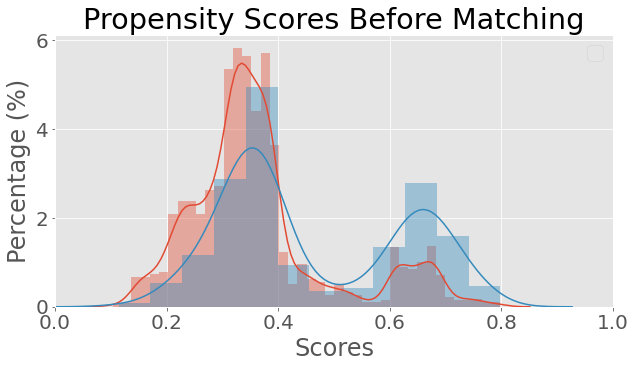

In [ ]:
m.predict_scores()
m.plot_scores()
plt.legend('Did not receive an a-line', 'Did receive an a-line')

This shows how well "matched" our groups are feasibly. The ideal distributions would have an overlap everywhere from 0 - 1. Here, we can see that we do have a decent overlap from 0.05 - 0.8 - but no observations above 0.8 - which should be OK!

/usr/local/lib/python3.6/dist-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['match_id'] = match_ids
/usr/local/lib/python3.6/dist-packages/pymatch/Matcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['record_id'] = self.matched_data.index


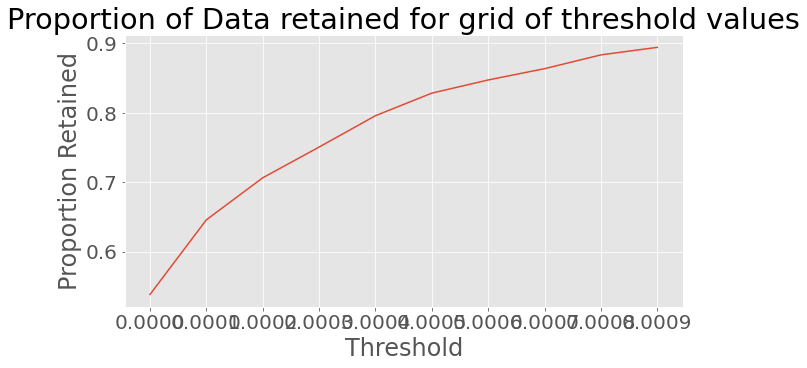

In [ ]:
m.tune_threshold(method='random')

/usr/local/lib/python3.6/dist-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['match_id'] = match_ids
/usr/local/lib/python3.6/dist-packages/pymatch/Matcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['record_id'] = self.matched_data.index


,var,before,after
0,gender,0.552001,0.215709
1,sedative_flag,0.000000,0.850111
2,chf_flag,0.109302,0.112342
3,afib_flag,0.295090,0.562573
4,renal_flag,0.371113,0.858033
5,liver_flag,0.625989,0.005725
6,copd_flag,0.001052,0.189324
7,cad_flag,0.456083,0.105929
8,stroke_flag,0.000100,0.717225
9,malignancy_flag,0.000287,0.026096


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,hour_icu_intime,0.018,0.065,0.0,0.041,0.264887,0.0,0.070924,-0.021220
1,icu_hour_flag,0.022,0.099,1.0,1.000,0.000000,0.0,0.093654,0.069814


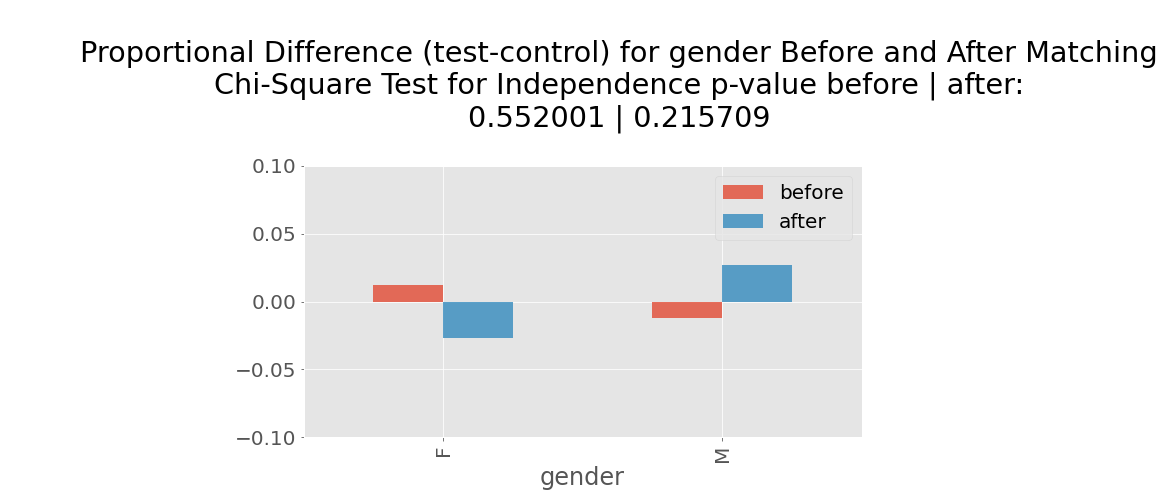

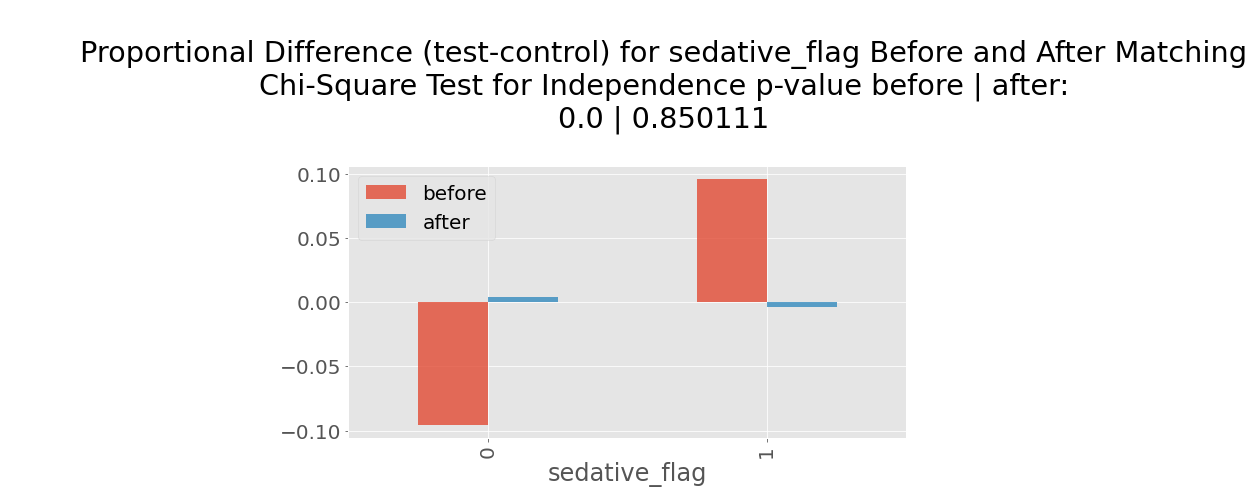

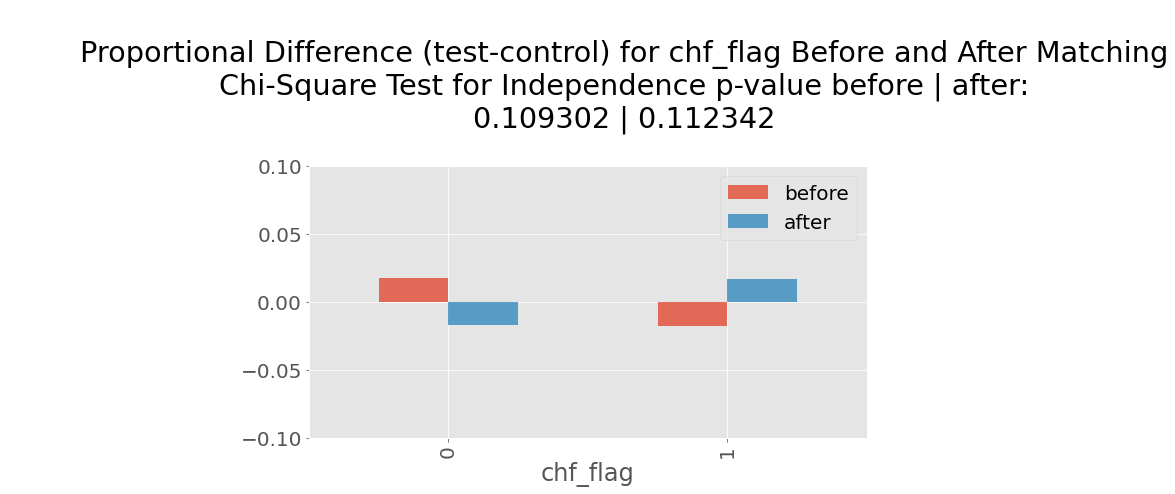

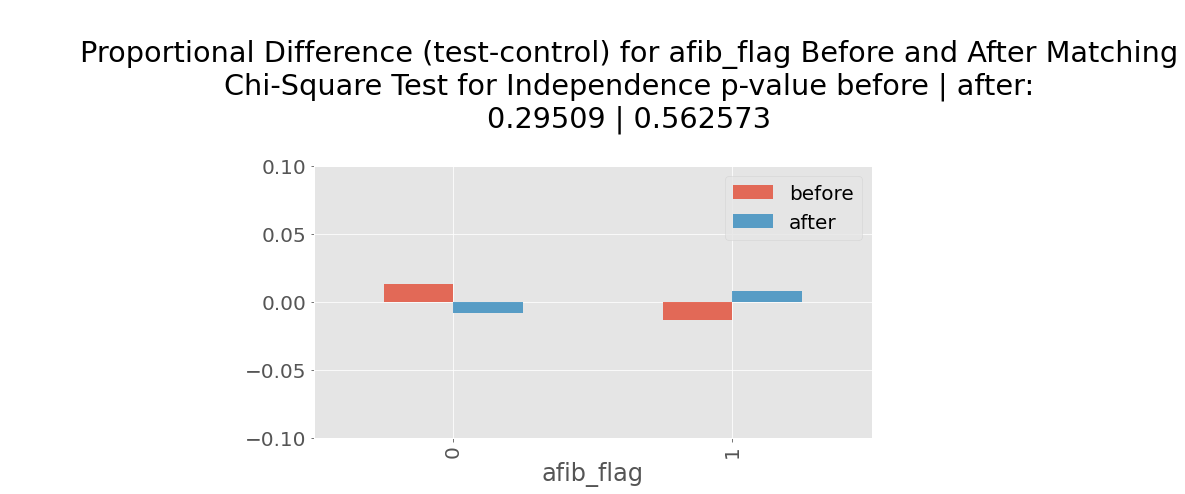

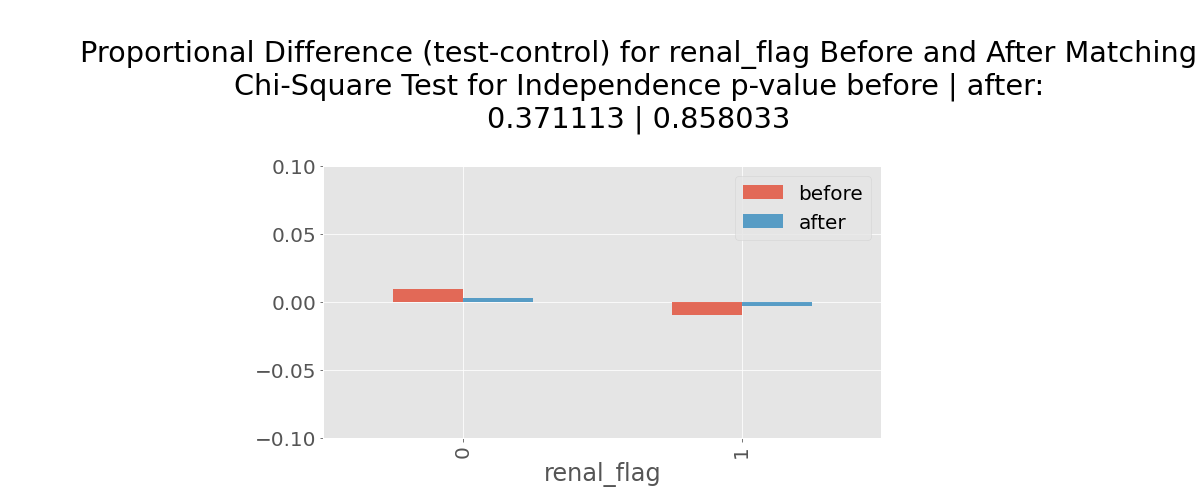

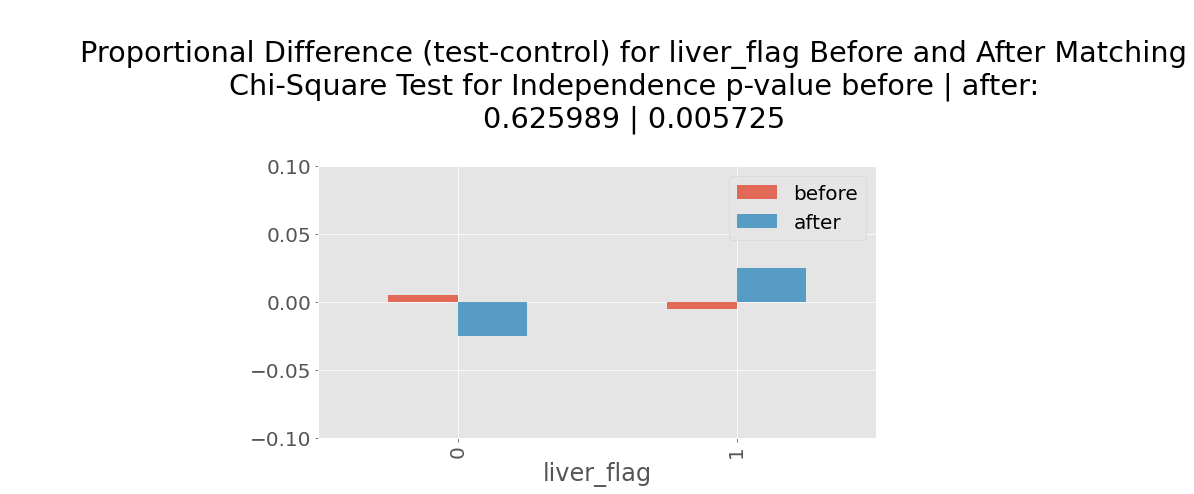

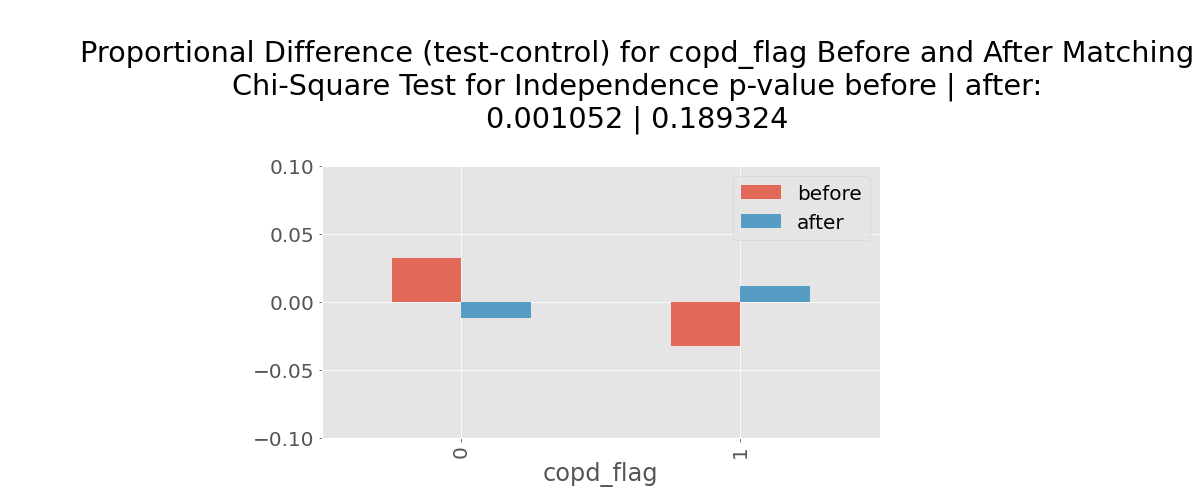

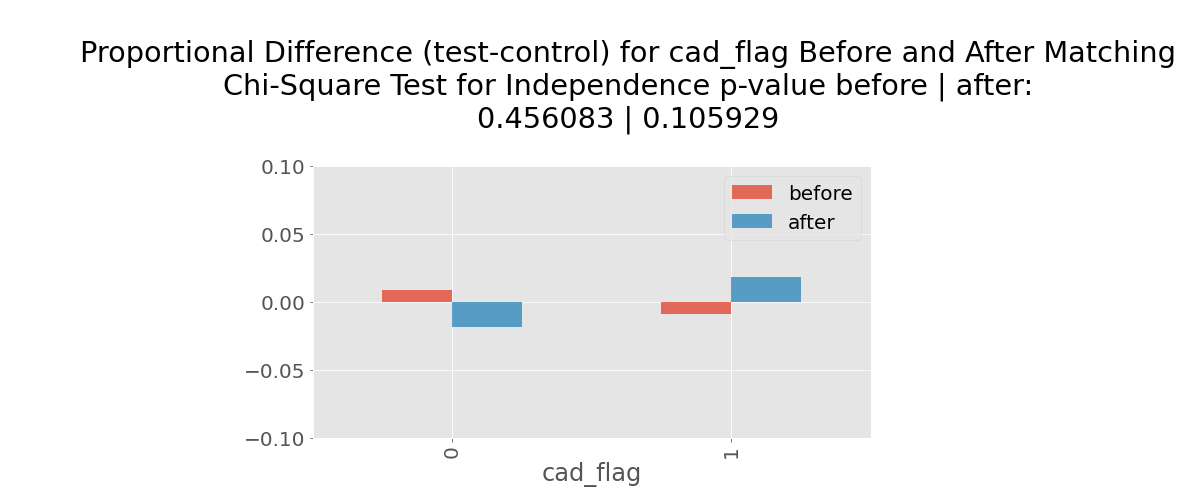

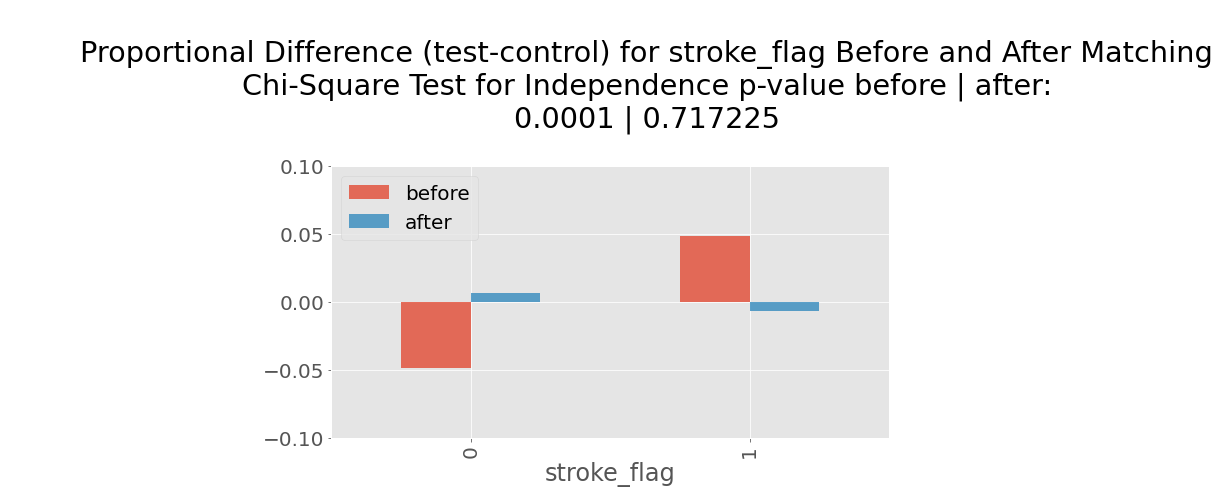

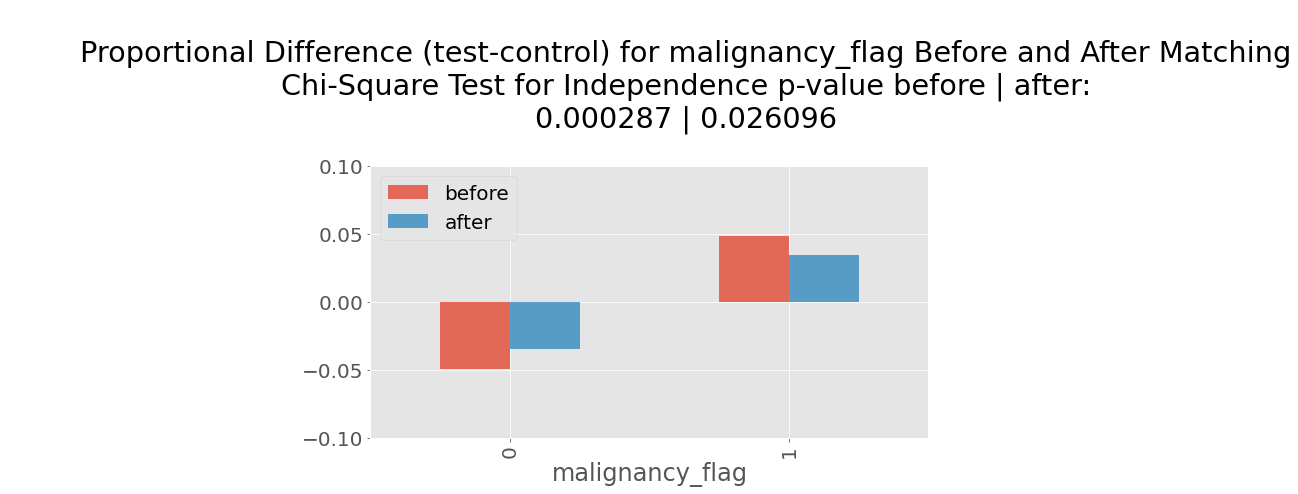

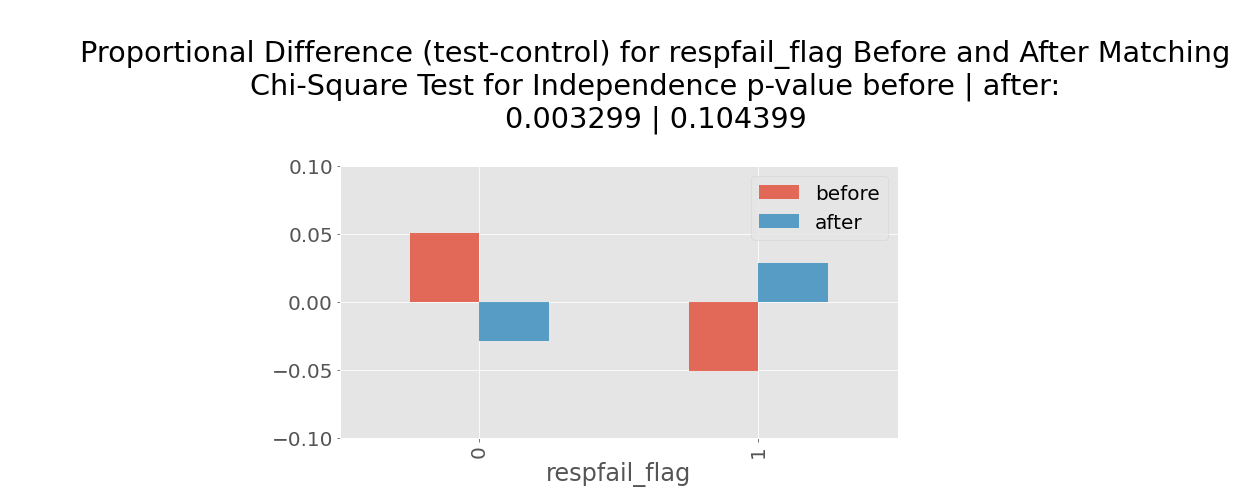

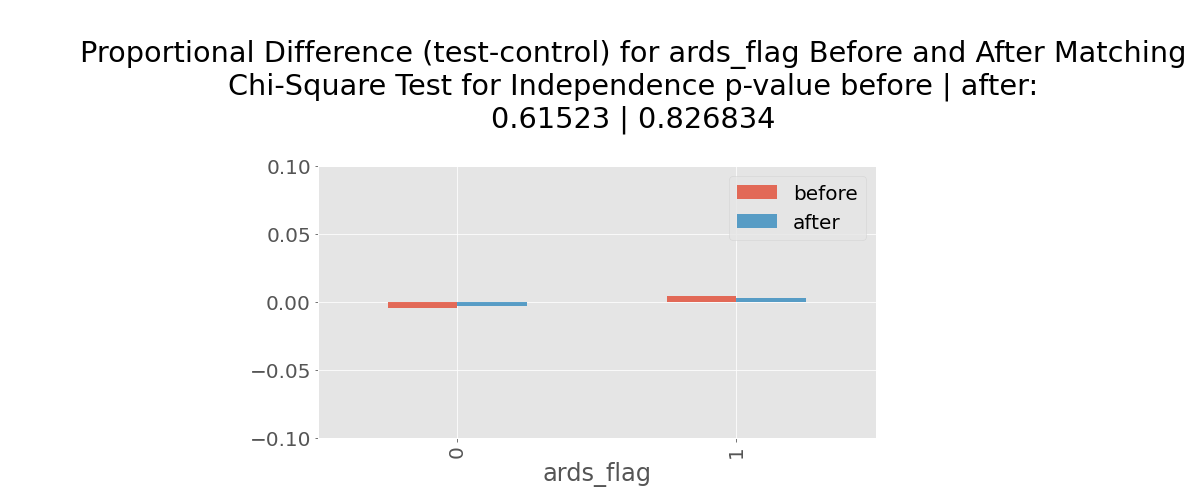

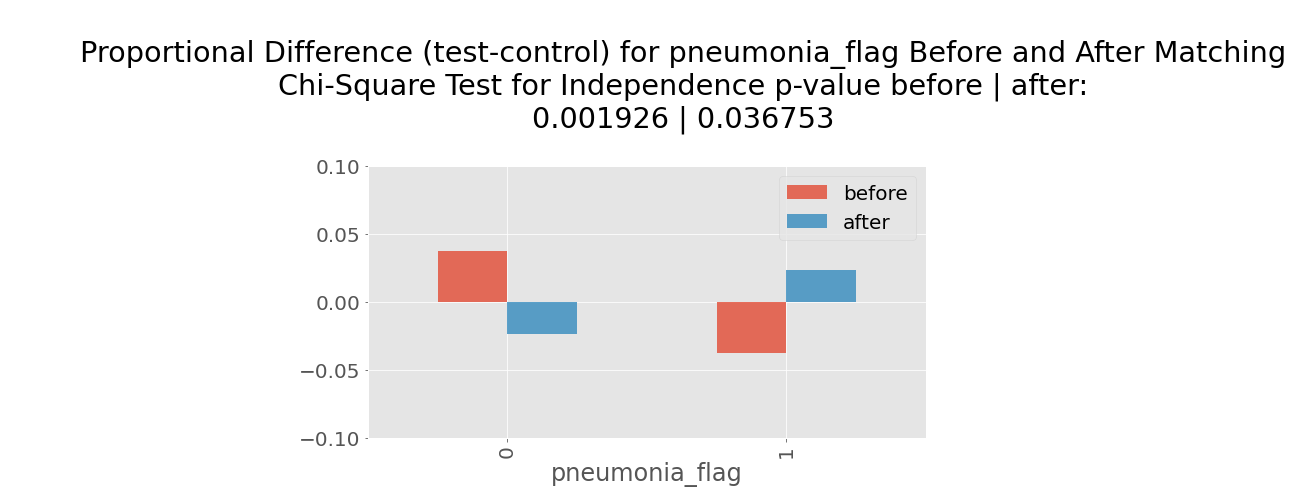

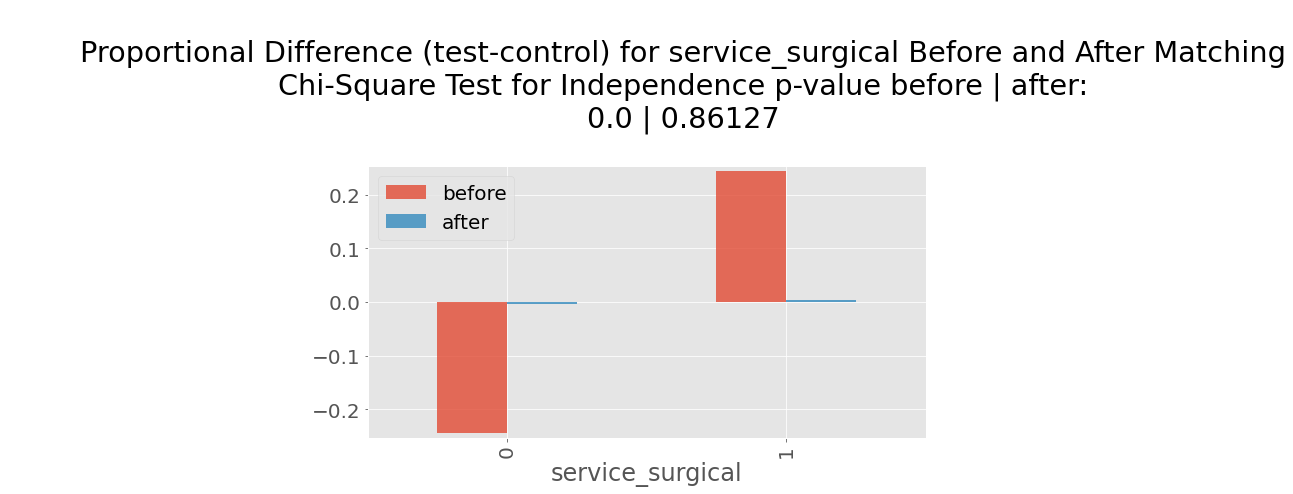

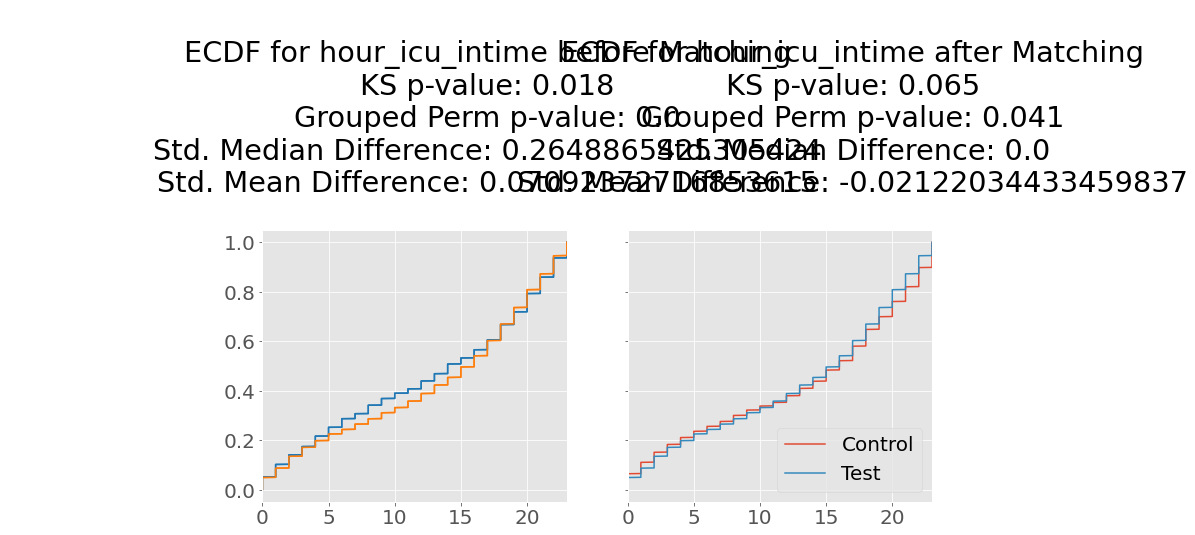

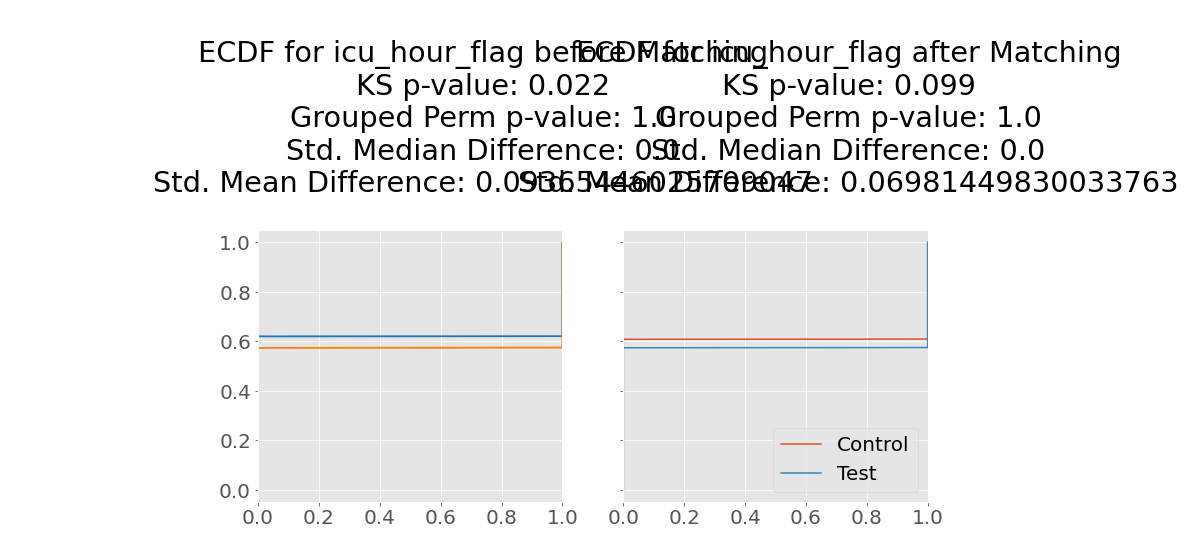

In [ ]:
# match patients together
m.match(method="min", nmatches=1, threshold=0.001)

# compare distribution of categorical variables
cc = m.compare_categorical(return_table=True)
display(cc)

# compare distribution of continous/binary variables
cc = m.compare_continuous(return_table=True)
display(cc)

In [ ]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'age', 'gender', 'icustay_intime',
       'hour_icu_intime', 'icu_hour_flag', 'icustay_outtime', 'icu_los_day',
       'hospital_los_day', 'hosp_exp_flag', 'icu_exp_flag', 'mort_day',
       'day_28_flag', 'mort_day_censored', 'censor_flag', 'aline_flag',
       'aline_time_day', 'weight_first', 'height_first', 'bmi', 'service_unit',
       'sofa_first', 'map_first', 'hr_first', 'temp_first', 'spo2_first',
       'bun_first', 'creatinine_first', 'chloride_first', 'hgb_first',
       'platelet_first', 'potassium_first', 'sodium_first', 'tco2_first',
       'wbc_first', 'chf_flag', 'afib_flag', 'renal_flag', 'liver_flag',
       'copd_flag', 'cad_flag', 'stroke_flag', 'malignancy_flag',
       'respfail_flag', 'endocarditis_flag', 'ards_flag', 'pneumonia_flag',
       'sedative_flag', 'dilaudid_flag', 'midazolam_flag', 'fentanyl_flag',
       'propofol_flag', 'service_surgical'],
      dtype='object')

In [ ]:
def get_contingency_tables(m, outcome_var):
    """Get 2x2xK contingency tables for matched pairs in propensity analysis.
    Contingency tables will be output in the following form:
    [
        Number exposed with outcome == 1, Number exposed with outcome == 0
        Number unexposed with outcome == 1, Number unexposed with outcome == 0
    ]
    The input match object must be populated with match using nmatches=1.
    """

    # in the matched object, m.yvar is the exposure variable
    df_matched = m.matched_data[['match_id', 'record_id', m.yvar, outcome_var]].copy()

    # determine the minority group
    # this group will be matched to more than one case
    idxMinority = df_matched[m.yvar] == m.minority

    df_matched = df_matched.loc[idxMinority].merge(
        df_matched.loc[~idxMinority],
        how='inner',
        on='match_id',
        suffixes=('_minority', '_majority')
    )

    # drop the redundant yvar column
    df_matched.drop(
        [f'{m.yvar}_{s}' for s in ('minority', 'majority')],
        axis=1,
        inplace=True
    )

    # group them by the strata
    df_grouped = df_matched.groupby(
        ['record_id_minority', f'{outcome_var}_minority', f'{outcome_var}_majority']
    )[['match_id']].count()
    df_grouped = df_grouped.reset_index()

    K = df_grouped['record_id_minority'].nunique()
    cm = np.zeros([2, 2, K])

    # pivot the dataframe into a 2x2xK contingency table
    # we do this by creating the i/j/k indices, then inserting the count into a matrix of 0s

    # create an integer grouped by the strata
    df_grouped['k'] = df_grouped['record_id_minority'].rank(method='dense'
                                                            ).astype(int) - 1

    # below we guarantee the exposed cases are in the 0th row
    if m.minority == 1:
        # if minority are exposed, then majority should go in [1, :]
        i = np.ones(df_grouped.shape[0], dtype=int)
    else:
        # if minority are *not* exposed, then majority are exposed
        # therefore, place majority cases in [0, :]
        i = np.zeros(df_grouped.shape[0], dtype=int)
    j = 1 - df_grouped[f'{outcome_var}_majority']
    k = df_grouped['k']

    # insert the count of observations
    cm[i, j, k] = df_grouped['match_id']

    # now drop the non-minority rows, we have 1 match for each
    df_grouped.drop_duplicates(
        ['record_id_minority'], keep='first', inplace=True
    )
    # i is 1 if the minority class is the non-exposed class
    if m.minority == 1:
        # i is 0 if the minority class is the exposed class
        i = np.zeros(K, dtype=int)
    else:
        i = np.ones(K, dtype=int)

    # ensure that events occuring are placed in the 0th column
    # ensure that non-events are placed in the 1st column
    j = 1 - df_grouped[f'{outcome_var}_minority']
    k = df_grouped['k']
    cm[i, j, k] = 1

    return cm

def cmh_test(
    x, alpha=0.05, exact=False, test_type='two-sided', continuity=True
):
    """Cochran Mantel Haenszel estimate of exposure adjusting for confounding.
    x should be a 2x2xK contingency table, where K is the number of strata for
    the confounding variable.
    """
    # x should be 2x2xK
    assert len(x.shape) == 3
    assert x.shape[0:2] == (2, 2)

    # total cases in each strata
    T = x.sum(axis=0).sum(axis=0)

    # need at least 1 sample in each stratum
    assert all(T > 0)

    I, J, K = x.shape

    # row/column totals used in the statistic
    n1i = x.sum(axis=1)[0, :]
    n2i = x.sum(axis=1)[1, :]
    m1i = x.sum(axis=0)[0, :]
    m2i = x.sum(axis=0)[1, :]

    # We test against a chi2 statistic with dof 1
    statistic = np.sum(x[0, 0, :] - (n1i * m1i / T))
    statistic_sign = np.sign(statistic)

    # Yates continuity correction
    if continuity & (np.abs(statistic) >= 0.5):
        statistic = np.abs(statistic) - 0.5

    statistic = statistic**2 / np.sum(
        n1i * n2i * m1i * m2i / (np.power(T, 2) * (T - 1))
    )

    if test_type != 'two-sided':
        # if one sided, take the square root and do z-test
        statistic = np.sqrt(statistic) * statistic_sign
        pval = norm.sf(statistic)
    else:
        # calculate the p-value for the statistic: 1 dof chi2
        pval = chi2.sf(statistic, df=1)

    # common odds-ratio (Mantel-Haenszel, 1959)
    main_diag_sum = np.sum(x[0, 0, :] * x[1, 1, :] / T)
    off_diag_sum = np.sum(x[0, 1, :] * x[1, 0, :] / T)
    R = main_diag_sum / off_diag_sum

    # Robins et al. (1986) estimate of the standard deviation of log CMH
    term1 = np.sum(
        (x[0, 0, :] + x[1, 1, :]) * x[0, 0, :] * x[1, 1, :] / np.power(T, 2)
    ) / (2 * np.power(main_diag_sum, 2))
    term2 = np.sum(
        (
            (x[0, 0, :] + x[1, 1, :]) * x[0, 1, :] * x[1, 0, :] +
            (x[0, 1, :] + x[1, 0, :]) * x[0, 0, :] * x[1, 1, :]
        ) / np.power(T, 2)
    ) / (2 * main_diag_sum * off_diag_sum)
    term3 = np.sum(
        (x[0, 1, :] + x[1, 0, :]) * x[0, 1, :] * x[1, 0, :] / np.power(T, 2)
    ) / (2 * np.power(off_diag_sum, 2))
    sigma = np.sqrt(term1 + term2 + term3)

    # un-log the estimate to get confidence intervals
    ci_lower = R * np.exp(1 * norm.ppf(alpha / 2) * sigma)
    ci_upper = R * np.exp(-1 * norm.ppf(alpha / 2) * sigma)

    return pval, R, (ci_lower, ci_upper)

In [ ]:
# calculate a contingency table for each "strata"
# here the strata are a match between a single patient in the minority group
# and 1 or more patients in the majority group
cm = get_contingency_tables(m, outcome_var=outcome_var)

# mcnemar's test to see if indwelling arterial catheter related to mortality using matched pairs
# STATISTICAL SIGNIFICANCE: reject the null hypothesis that mortality rates in the two groups are the same
# Cochran Mantel Haenszel estimate of exposure adjusting for confounding.
# CMH is a generalization of the McNemar test, where there can be multiple contingency tables.
pval, R, ci = cmh_test(cm, alpha=0.05)
pval_str = f'= {pval:1.3f}' if pval > 0.001 else '< 0.001'

print('Result of propensity score followed by matching:')
print(f'p {pval_str}.\nOdds ratio: {R:3.2f} [{ci[0]:3.2f} - {ci[1]:3.2f}].')

Result of propensity score followed by matching:
p = 0.339.
Odds ratio: 0.88 [0.68 - 1.13].


The above p-value, which is > 0.05, tells us that we cannot reject the null hypothesis of the aline/non-aline groups having the same mortality rate. Assuming all assumptions of our modelling process are correct, we can infer from this that the use of an indwelling arterial catheter is not associated with a mortality benefit in these patients. This was the conclusion of the arterial line paper which we aimed to replicate. Hurray!